In [ ]:
import netsim_summariser as summ

In [111]:
from importlib import reload
reload(summ)

<module 'netsim_summariser' from '/home/davidwu/REPOS/echidna_network/netsim_summariser.py'>

In [5]:
import itertools
import numpy as np
from scipy import stats
import polars as pl
from matplotlib import pyplot as plt, cycler
import seaborn as sns

sns.set()

In [6]:
RECOMPUTE_METRICS = False

In [7]:
if RECOMPUTE_METRICS:
    summarise_snapshots = summ.Summariser("./zero_sims/snapshot/sim_all.h5")
    
    snapshot_results = summarise_snapshots.collect(over=None, ncpus=6, no_move=True, verbose=False)

    snapshot_df = summarise_snapshots.results_to_polars(snapshot_results, drop=[])

    snapshot_df.write_parquet("./zero_sims/snapshot/metrics.parquet")
else:
    snapshot_df = pl.read_parquet("./zero_sims/snapshot/metrics.parquet")

<Axes: xlabel='seed', ylabel='extent'>

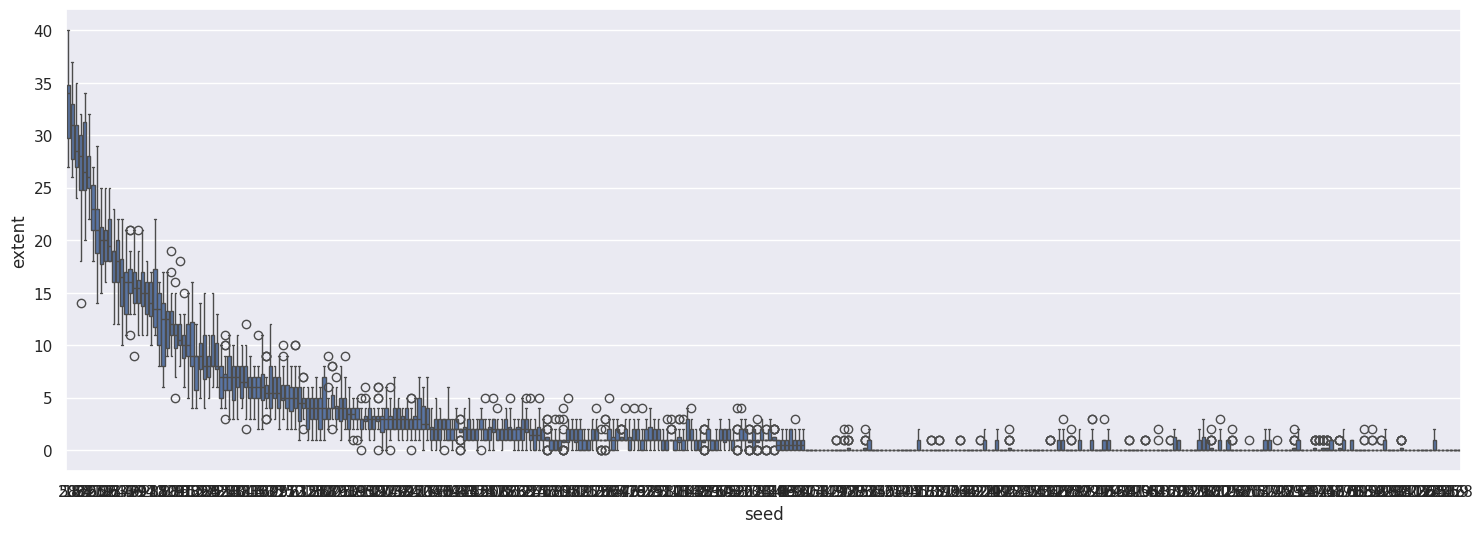

In [8]:
fig, ax = plt.subplots(figsize=(18, 6))

snapshot_median_extent = snapshot_df.group_by('seed').median().select('seed', 'extent')
sorder = snapshot_median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

sns.boxplot(
    snapshot_df.select('seed', 'extent'),
    x='seed',
    y='extent',
    order=sorder,
    orient='v',
    ax=ax,
)

In [9]:
if RECOMPUTE_METRICS:
    summ_statichome = summ.Summariser("./zero_sims/static/sim_all.h5")
    
    statichome_results = summ_statichome.collect(over=None, ncpus=6, no_move=True, verbose=False)
    
    statichome_df = summ_statichome.results_to_polars(statichome_results, drop=[])

    statichome_df.write_parquet("./zero_sims/static/metrics.parquet")
else:
    statichome_df = pl.read_parquet("./zero_sims/static/metrics.parquet")

<Axes: xlabel='seed', ylabel='extent'>

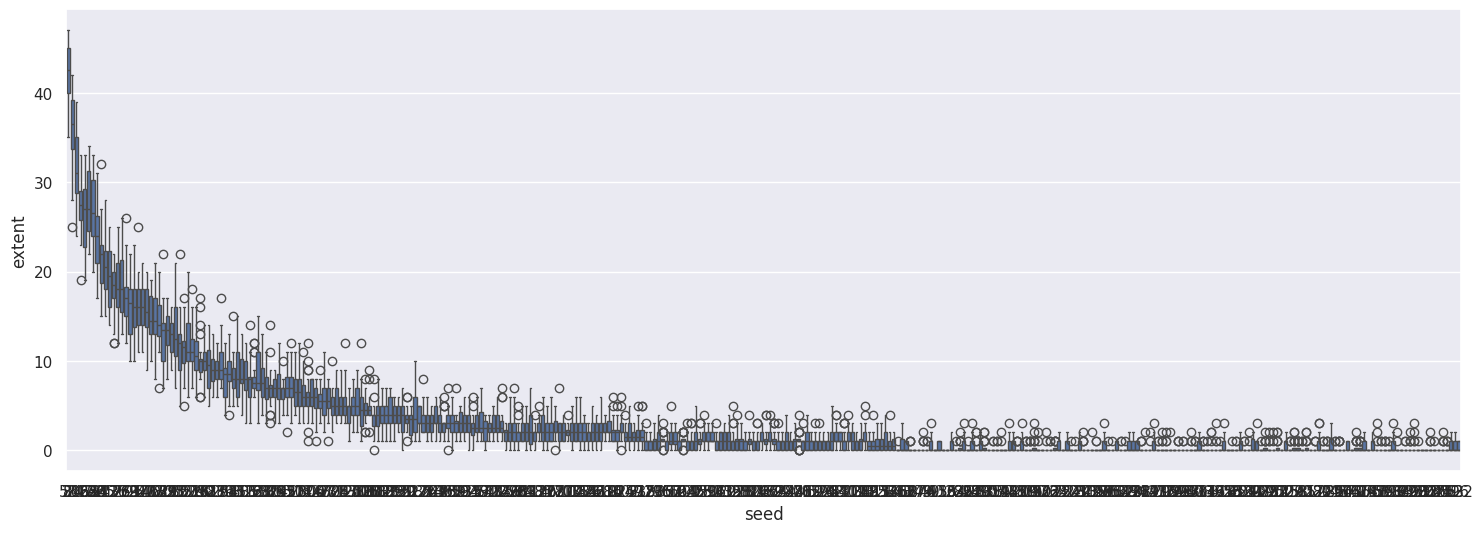

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))

statichome_median_extent = statichome_df.group_by('seed').median().select('seed', 'extent')
shorder = statichome_median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

sns.boxplot(
    statichome_df.select('seed', 'extent'),
    x='seed',
    y='extent',
    order=shorder,
    orient='v',
    ax=ax,
)

In [97]:
if RECOMPUTE_METRICS:
    summ_staticnosh = summ.Summariser("./zero_sims/static/noselfloop_sim_all.h5")
    
    staticnosh_results = summ_staticnosh.collect(over=None, ncpus=6, no_move=True, verbose=False)
    
    staticnosh_df = summ_staticnosh.results_to_polars(staticnosh_results, drop=[])
    
    staticnosh_df.write_parquet("./zero_sims/static/nosh_metrics.parquet")
else:
    staticnosh_df = pl.read_parquet("./zero_sims/static/nosh_metrics.parquet")

<Axes: xlabel='seed', ylabel='extent'>

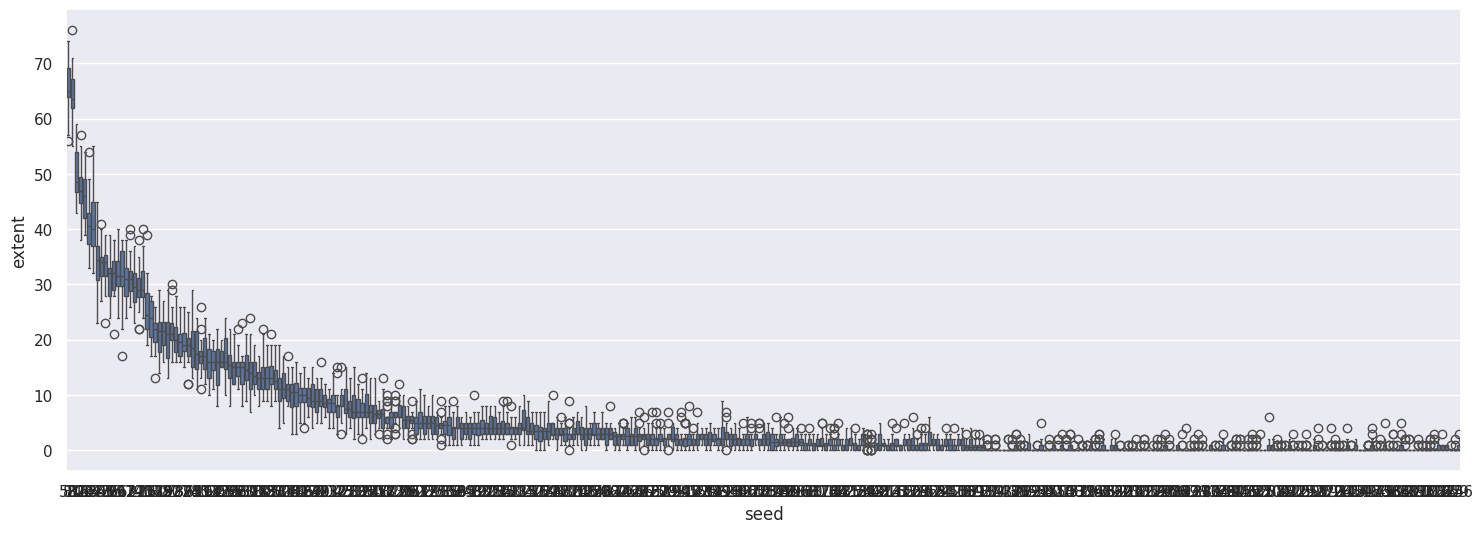

In [98]:
fig, ax = plt.subplots(figsize=(18, 6))

staticnosh_median_extent = staticnosh_df.group_by('seed').median().select('seed', 'extent')
snorder = staticnosh_median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

sns.boxplot(
    staticnosh_df.select('seed', 'extent'),
    x='seed',
    y='extent',
    order=snorder,
    orient='v',
    ax=ax,
)

In [115]:
if True:
    summ_temporal = summ.Summariser("zero_sims/temporal/all_sims.h5")
    
    # temporal_results = summ_temporal.collect(over=None, no_move=True, verbose=False)
    
    temporal_df = summ.Metrics(summ_temporal.results_to_polars(temporal_results, drop=()))
    temporal_df = temporal_df.add_extent(30)

    temporal_df.write_parquet("./zero_sims/temporal/metrics.parquet")
else:
    temporal_df = pl.read_parquet("./zero_sims/temporal/metrics.parquet")

<Axes: xlabel='seed', ylabel='extent'>

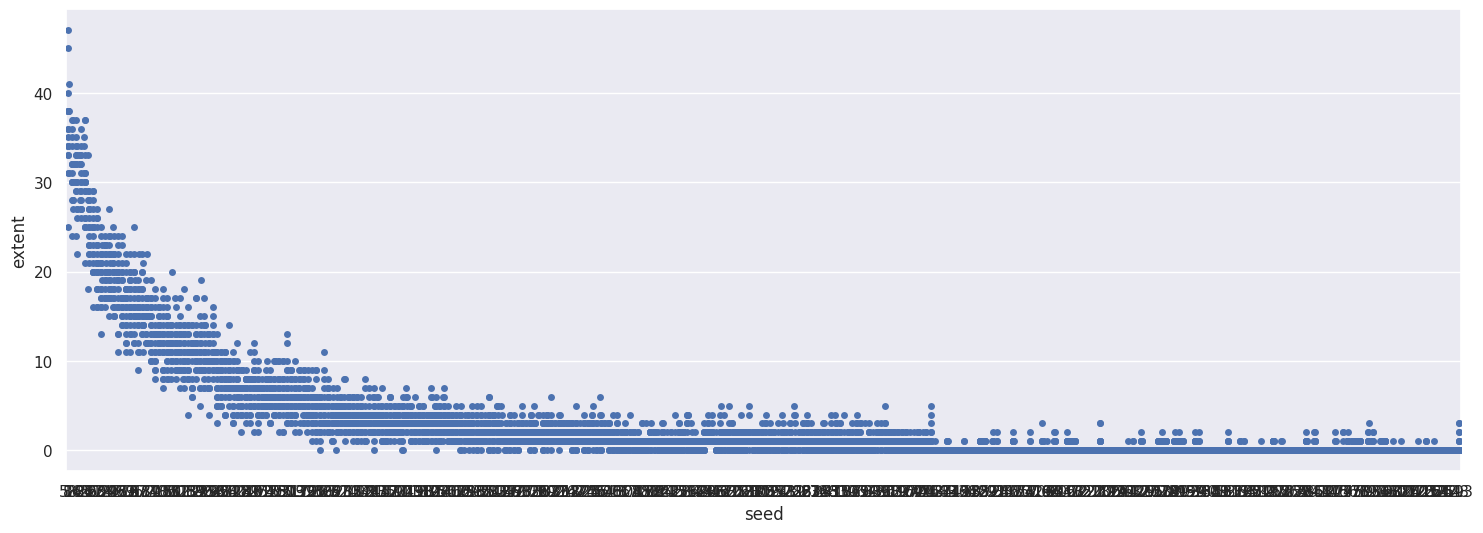

In [131]:
fig, ax = plt.subplots(figsize=(18, 6))

temporal_median_extent = temporal_df.group_by('seed').median().select('seed', 'extent')
torder = temporal_median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

sns.stripplot(
    temporal_df.select('seed', 'extent'),
    x='seed',
    y='extent',
    order=torder,
    orient='v',
    ax=ax,
)

In [144]:
combined_median_df = pl.concat(
    [df.with_columns(pl.lit(label).alias('simulation'))
     for label, df in zip(['static', 'snapshot', 'temporal'], [statichome_median_extent, snapshot_median_extent, temporal_median_extent])]
)

combined_median_sort = combined_median_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_median_df = combined_median_df.join(combined_median_sort, on='seed')

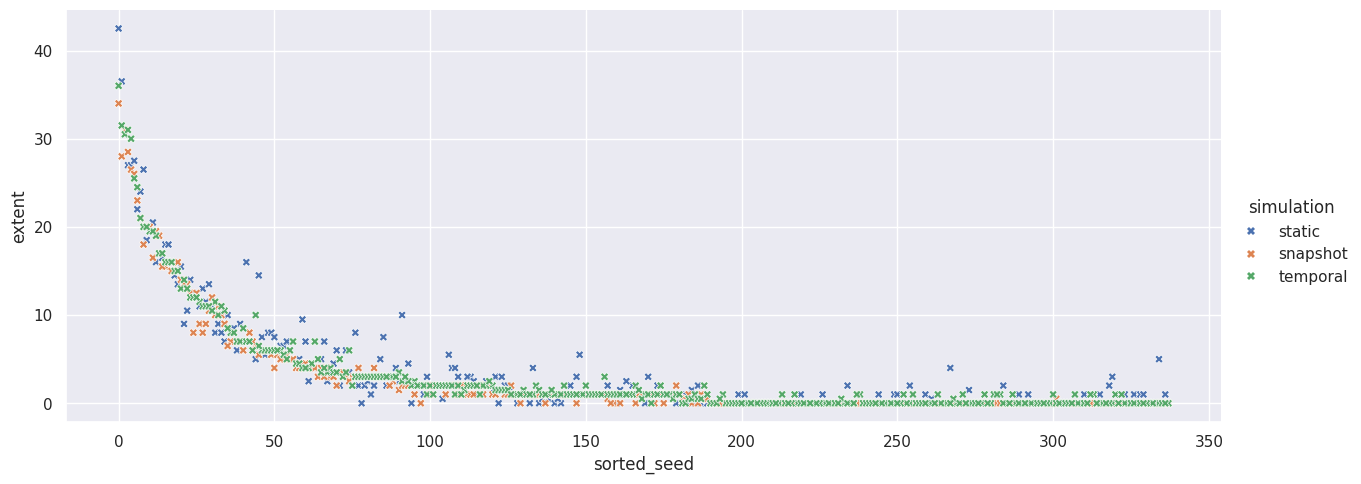

In [145]:
sns.relplot(
    combined_median_df,
    x='sorted_seed',
    y='extent',
    hue='simulation',
    marker='X',
    aspect=2.5,
).savefig("zero_extent_median_comparison.png", dpi=200)


In [139]:
combined_all_df = pl.concat(
    [df.select('seed', 'extent').with_columns(pl.lit(label).alias('simulation'), pl.col('extent').cast(pl.Int64))
     for label, df in zip(['static', 'snapshot', 'temporal'], [statichome_df, snapshot_df, temporal_df])]
)

combined_sort_order = combined_all_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_all_df = combined_all_df.join(combined_sort_order, on='seed')

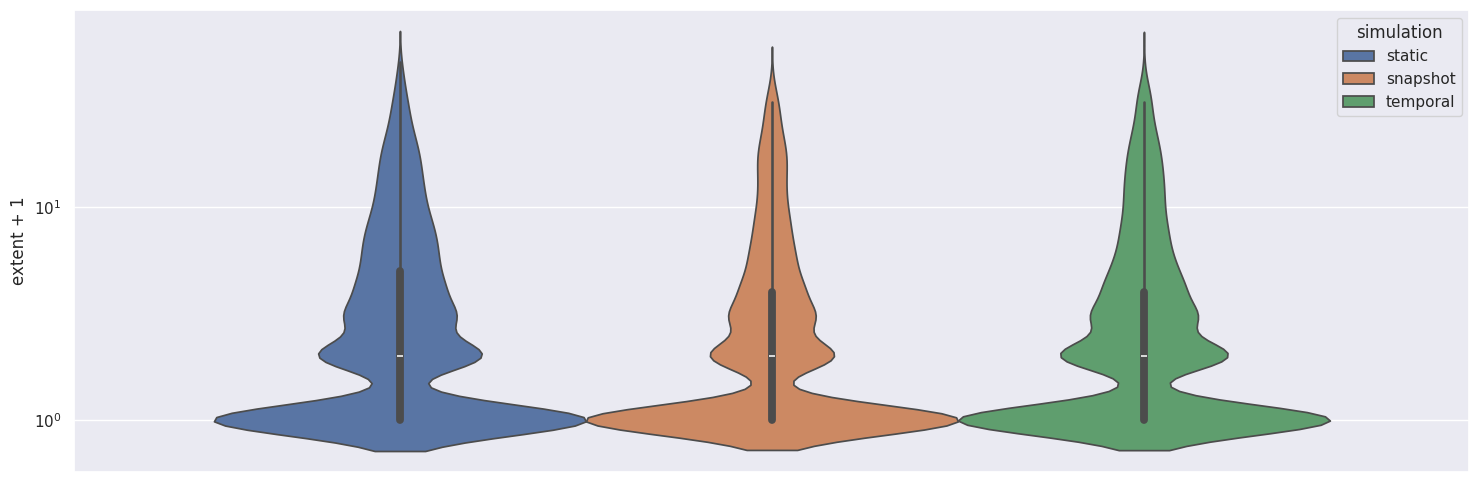

In [165]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.violinplot(
    combined_all_df.with_columns(pl.col('extent')+1),
    # x='sorted_seed',
    y='extent',
    hue='simulation',
    log_scale=(True),
    # kind='box',
    # marker='.',
    # alpha=0.6,
    # aspect=2.5,
    ax=ax,
)
ax.set_ylabel('extent + 1')
# ).savefig("zero_extent_all_comparison.png", dpi=200)
fig.savefig('zero_extent_all_comparison.png', dpi=200)

In [146]:
paired_median_df = combined_median_df.pivot("simulation", index="sorted_seed", values="extent")

In [147]:
for p1, p2 in itertools.combinations(['static', 'snapshot', 'temporal'], 2):
    print(p1, 'vs', p2)
    print(stats.ttest_rel(paired_median_df[p1], paired_median_df[p2], alternative='two-sided'))

static vs snapshot
TtestResult(statistic=5.732195290326988, pvalue=2.202681065306734e-08, df=337)
static vs temporal
TtestResult(statistic=2.5357715013168196, pvalue=0.01167128102905994, df=337)
snapshot vs temporal
TtestResult(statistic=-6.873659515042515, pvalue=3.0405444030118785e-11, df=337)


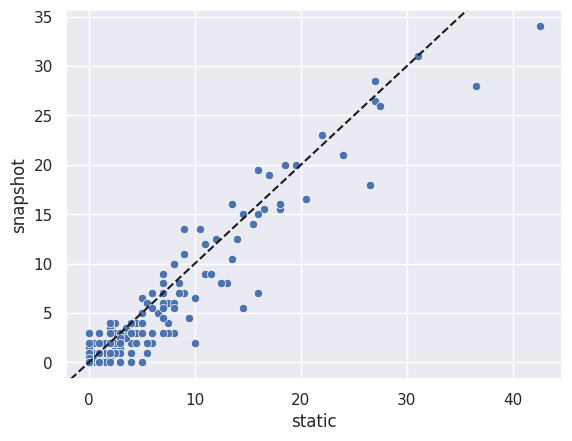

In [148]:
sns.scatterplot(paired_median_df, x='static', y='snapshot')
plt.axline((0,0), slope=1, color='k', linestyle='dashed')

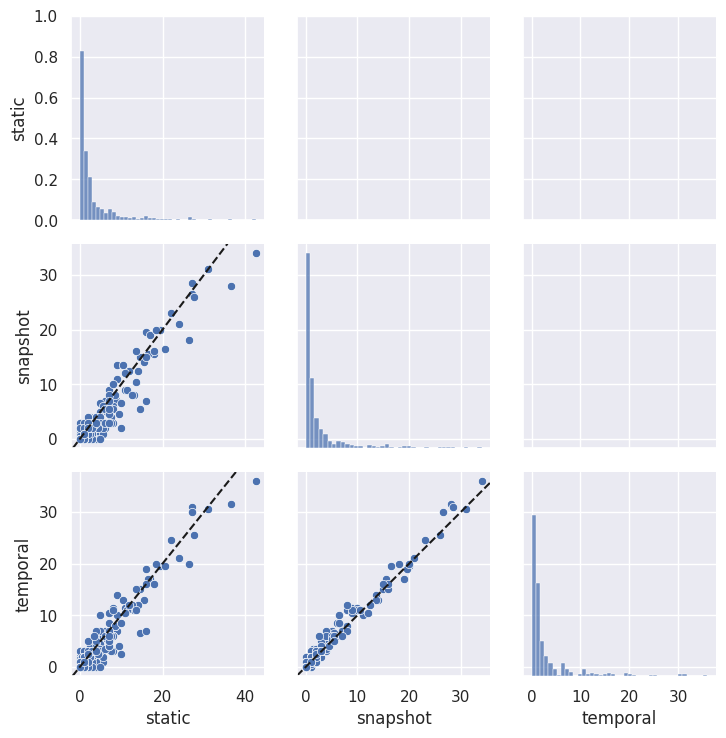

In [149]:
ppl = sns.PairGrid(paired_median_df.to_pandas(), vars=['static', 'snapshot', 'temporal'])
ppl.map_lower(sns.scatterplot)
ppl.map_diag(sns.histplot)
# ppl.map_upper(sns.scatterplot)
ppl.map_lower(lambda *a, **k: plt.axline((0,0), slope=1, linestyle='dashed', color='k'))
ppl.savefig('zero_median_extent_pairedplot.png', dpi=200)

In [123]:
def extract_reappearance_time(df):

    reappearances = df.select(
        pl.col('seed'),
        pl.concat_list(pl.selectors.starts_with('hitting_time'))
        .list.eval(pl.element().filter(pl.element().is_not_null()).sort(), parallel=True)
        .list.get(1, null_on_oob=True)
        .alias('reappearance_time')
    )

    return reappearances

def get_sort_order(df, order='seed', by='reappearance_time'):
    return df.group_by(order).median().sort(by, descending=True).select(order).to_series().to_list()


In [67]:
reapp_snap = extract_reappearance_time(snapshot_df)

In [68]:
reapp_static = extract_reappearance_time(statichome_df)

In [124]:
reapp_temporal = extract_reappearance_time(temporal_df)

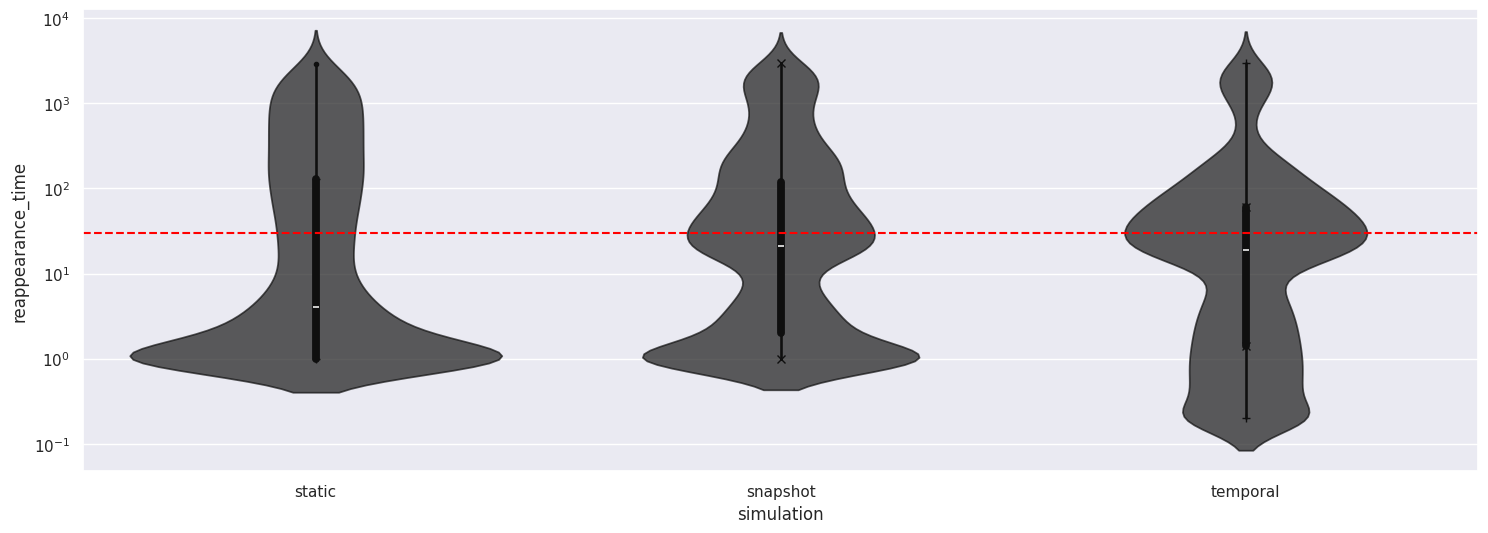

In [167]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_prop_cycle(cycler(marker=['.', '+', 'x']))
# sns.boxplot(reapp_snap, y='reappearance_time', x='seed', orient='v', order=rsx_order, ax=ax)

combined_reapp = pl.concat(
    [df.with_columns(pl.lit(label).alias('simulation'), 
                     (1.0 / pl.col('reappearance_time')).alias('reappearance_rate')
                    )
                     for label, df in zip(
                         ['static', 'snapshot', 'temporal'], 
                         [reapp_static, reapp_snap, reapp_temporal]
                     )
    ]
)


reapp_order = get_sort_order(combined_reapp, by='reappearance_rate')

sns.violinplot(combined_reapp, y='reappearance_time', x='simulation',  orient='v', ax=ax, log_scale=(False, True), alpha=0.7,)
plt.axhline(30, color='red', linestyle='dashed')
fig.savefig('zero_reappearance_time.png', dpi=200)
